# 12강: CNN 모델 구현과 성능 평가

## 🎯 학습 목표
- PyTorch로 CNN 모델을 직접 구현하고 학습
- 이미지 분류 성능 평가 방법 이해
- MNIST 데이터셋에서 MLP vs CNN 성능 비교 분석
- 실제 이미지 분류 프로젝트 수행

---

## 📚 강의 개요 (60분)
1. CNN 모델 구현 (20분)
2. MNIST MLP vs CNN 성능 비교 (20분)
3. 성능 평가 및 시각화 (20분)

> **이전 강의 복습**: 11강에서 CNN의 이론적 배경과 컨볼루션 레이어의 원리를 학습했습니다!


## 1. 환경 설정 및 라이브러리 임포트


In [ ]:
# !pip install -U Pillow

In [2]:
!pip install seaborn

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time

# 한글 폰트 설정
import matplotlib.font_manager as fm
f = [f.name for f in fm.fontManager.ttflist]
# print(f)
# 확인 이후
plt.rc('font', family='Malgun Gothic')

# 시드 설정으로 재현 가능한 결과 보장
torch.manual_seed(42)
np.random.seed(42)

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 디바이스: {device}')
if torch.cuda.is_available():
    print(f'GPU 이름: {torch.cuda.get_device_name(0)}')


C:\Users\jungh\Anaconda3\envs\aibasic\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\jungh\Anaconda3\envs\aibasic\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


사용 디바이스: cuda
GPU 이름: NVIDIA GeForce GTX 1650


## 2. MNIST 데이터셋 준비

**📊 MNIST 데이터셋 소개:**
- 손글씨 숫자 (0-9) 이미지 데이터셋
- 훈련용: 60,000개, 테스트용: 10,000개
- 이미지 크기: 28×28 픽셀 (흑백)
- 컴퓨터 비전 분야의 "Hello World"


In [2]:
# 데이터 전처리 파이프라인
transform = transforms.Compose([
    transforms.ToTensor(),  # PIL 이미지를 텐서로 변환 (0-1 정규화)
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 평균과 표준편차로 정규화
])

# 데이터셋 로드
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# 데이터 로더 생성
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'훈련 데이터 개수: {len(train_dataset)}')
print(f'테스트 데이터 개수: {len(test_dataset)}')
print(f'배치 크기: {batch_size}')
print(f'훈련 배치 개수: {len(train_loader)}')
print(f'테스트 배치 개수: {len(test_loader)}')


훈련 데이터 개수: 60000
테스트 데이터 개수: 10000
배치 크기: 128
훈련 배치 개수: 469
테스트 배치 개수: 79


## 3. 모델 정의 - 간단한 방식으로!

### 3.1 다층 퍼셉트론 (MLP) 모델
**🎯 간단한 구현**: 클래스 대신 `nn.Sequential`을 사용


In [3]:
# 🧠 MLP 모델을 간단하게 만들어보자!
# nn.Sequential을 사용하면 레이어들을 순서대로 쌓기만 하면 됩니다.

mlp_model = nn.Sequential(
    # 1. 이미지를 1차원으로 펼치기 (28x28 = 784)
    nn.Flatten(),
    
    # 2. 첫 번째 완전연결층 (784 -> 512)
    nn.Linear(784, 512),
    nn.ReLU(),                    # 활성화 함수
    nn.Dropout(0.2),             # 과적합 방지
    
    # 3. 두 번째 완전연결층 (512 -> 512)
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    
    # 4. 출력층 (512 -> 10개 클래스)
    nn.Linear(512, 10)
).to(device)

print("🧠 MLP 모델 구조:")
print(mlp_model)
print(f"\n📊 MLP 모델 파라미터 수: {sum(p.numel() for p in mlp_model.parameters()):,}개")

# 🔍 각 레이어별 파라미터 수 확인해보기
print("\n📋 레이어별 파라미터 수:")
for i, layer in enumerate(mlp_model):
    if hasattr(layer, 'weight'):
        print(f"   레이어 {i}: {layer.__class__.__name__} - {layer.weight.numel():,}개 파라미터")


🧠 MLP 모델 구조:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=512, out_features=10, bias=True)
)

📊 MLP 모델 파라미터 수: 669,706개

📋 레이어별 파라미터 수:
   레이어 1: Linear - 401,408개 파라미터
   레이어 4: Linear - 262,144개 파라미터
   레이어 7: Linear - 5,120개 파라미터


### 3.2 CNN 모델
**🔥 CNN도 마찬가지로 간단하게!** 레고 블록 쌓듯이 레이어를 차례대로 연결해보겠습니다.


In [4]:
# 🔥 CNN 모델을 레고 블록처럼 쌓아보자!
# 입력: 28x28x1 (흑백 이미지) → 출력: 10개 클래스

cnn_model = nn.Sequential(
    # 📸 첫 번째 컨볼루션 블록
    nn.Conv2d(1, 32, kernel_size=3, padding=1),    # 28x28x1 → 28x28x32
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),   # 28x28x32 → 28x28x64
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                            # 28x28x64 → 14x14x64
    
    # 📸 두 번째 컨볼루션 블록  
    nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 14x14x64 → 14x14x128
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1), # 14x14x128 → 14x14x128
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                            # 14x14x128 → 7x7x128
    
    # 🔄 이미지를 1차원으로 펼치기
    nn.Flatten(),                                  # 7x7x128 → 6272
    
    # 🧠 완전연결층 (분류기)
    nn.Linear(128 * 7 * 7, 512),                  # 6272 → 512
    nn.ReLU(),
    nn.Dropout(0.5),                               # 과적합 방지
    nn.Linear(512, 10)                             # 512 → 10개 클래스
).to(device)

print("🔥 CNN 모델 구조:")
print(cnn_model)
print(f"\n📊 CNN 모델 파라미터 수: {sum(p.numel() for p in cnn_model.parameters()):,}개")

# 🔍 CNN 레이어별 설명
print("\n📋 CNN 레이어별 역할:")
print("   🖼️  Conv2d: 이미지의 특징(선, 모서리 등)을 찾아냄")
print("   ⚡ ReLU: 음수를 0으로 만들어 학습 효율 높임") 
print("   📉 MaxPool2d: 이미지 크기를 줄여 연산량 감소")
print("   🔄 Flatten: 2D 이미지를 1D로 펼침")
print("   🧠 Linear: 최종 분류 결정")


🔥 CNN 모델 구조:
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=6272, out_features=512, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=512, out_features=10, bias=True)
)

📊 CNN 모델 파라미터 수: 3,457,162개

📋 CNN 레이어별 역할:
   🖼️  Conv2d: 이미지의 특징(선, 모서리 등)을 찾아냄
   ⚡ ReLU: 음수를 0으로 만들어 학습 효율 높임
   📉 MaxPool2d: 이미지 크기를 줄여 연산량 감소
   🔄 Flatten: 2D 이미지를 1D로 펼침
   🧠 Linear: 최종 분류 결정


### 3.3 데이터 샘플 확인하기
실제 MNIST 데이터가 어떻게 생겼는지 확인


🖼️  이미지 배치 크기: torch.Size([128, 1, 28, 28])
🏷️  레이블 배치 크기: torch.Size([128])


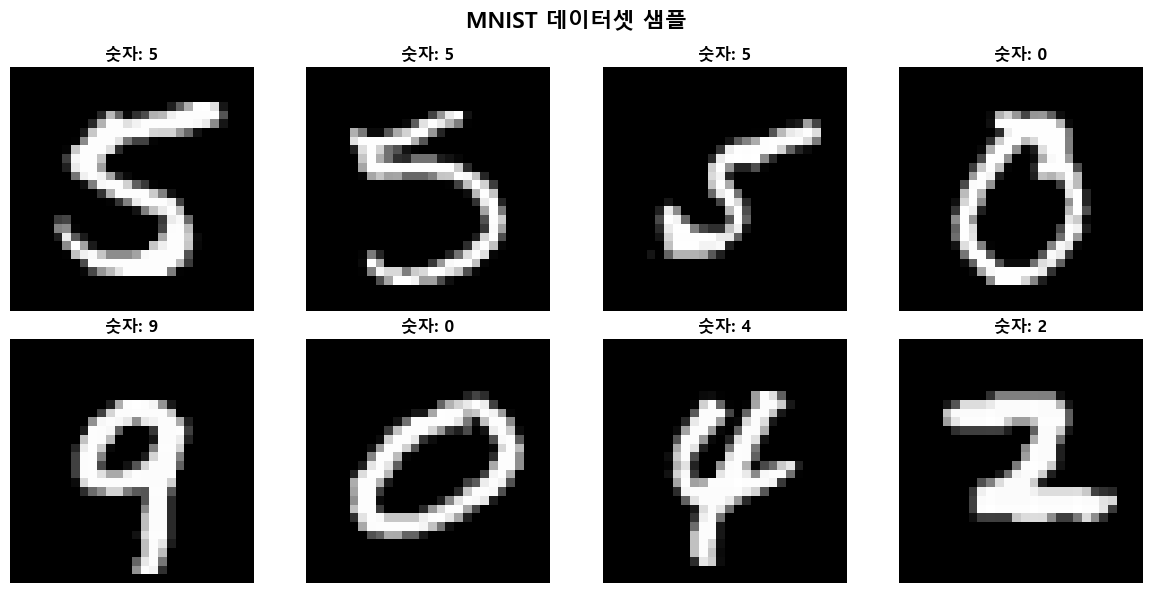

✅ 위 이미지들이 우리가 분류할 손글씨 숫자들입니다!

📊 데이터 정보:
   이미지 픽셀 값 범위: -0.424 ~ 2.821
   레이블 종류: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
   정규화 적용됨: 평균 ≈ 0, 표준편차 ≈ 1


In [5]:
# 📸 MNIST 데이터 샘플 확인하기
# 첫 번째 배치의 데이터 가져오기
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"🖼️  이미지 배치 크기: {images.shape}")  # [배치크기, 채널, 높이, 너비]
print(f"🏷️  레이블 배치 크기: {labels.shape}")  # [배치크기]

# 처음 8개 이미지 시각화
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('MNIST 데이터셋 샘플', fontsize=16, fontweight='bold')

for i in range(8):
    row = i // 4
    col = i % 4
    
    # 이미지 데이터 (텐서 → numpy 배열로 변환)
    img = images[i].squeeze().numpy()  # (1, 28, 28) → (28, 28)
    label = labels[i].item()
    
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(f'숫자: {label}', fontsize=12, fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("✅ 위 이미지들이 우리가 분류할 손글씨 숫자들입니다!")

# 🔍 데이터 정보
print(f"\n📊 데이터 정보:")
print(f"   이미지 픽셀 값 범위: {images.min():.3f} ~ {images.max():.3f}")
print(f"   레이블 종류: {torch.unique(labels).tolist()}")
print(f"   정규화 적용됨: 평균 ≈ 0, 표준편차 ≈ 1")


## 4. 학습 및 평가 함수


In [6]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    """모델 학습 함수"""
    model.train()
    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

def evaluate_model(model, test_loader):
    """모델 평가 함수"""
    model.eval()
    test_loss = 0
    correct = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            predictions.extend(pred.cpu().numpy().flatten())
            true_labels.extend(target.cpu().numpy())
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    
    return test_loss, accuracy, predictions, true_labels


## 5. MLP vs CNN 성능 비교

### 5.1 MLP 모델 학습


In [7]:
print("🧠 MLP 모델 학습 시작!")
print("=" * 50)

# MLP 모델 학습 설정
mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# MLP 학습 시간 측정
mlp_start_time = time.time()
mlp_train_losses, mlp_train_accuracies = train_model(
    mlp_model, train_loader, mlp_criterion, mlp_optimizer, epochs=5
)
mlp_train_time = time.time() - mlp_start_time

print(f"\n✅ MLP 학습 완료! 소요 시간: {mlp_train_time:.2f}초")

# MLP 모델 평가
print("\n📊 MLP 모델 평가 중...")
mlp_test_loss, mlp_accuracy, mlp_predictions, mlp_true_labels = evaluate_model(mlp_model, test_loader)


🧠 MLP 모델 학습 시작!
Epoch 1/5, Batch 0/469, Loss: 2.3147
Epoch 1/5, Batch 100/469, Loss: 0.2459
Epoch 1/5, Batch 200/469, Loss: 0.2239
Epoch 1/5, Batch 300/469, Loss: 0.1189
Epoch 1/5, Batch 400/469, Loss: 0.1135
Epoch 1/5 - Loss: 0.2443, Accuracy: 92.69%
Epoch 2/5, Batch 0/469, Loss: 0.1813
Epoch 2/5, Batch 100/469, Loss: 0.1990
Epoch 2/5, Batch 200/469, Loss: 0.2641
Epoch 2/5, Batch 300/469, Loss: 0.0827
Epoch 2/5, Batch 400/469, Loss: 0.0761
Epoch 2/5 - Loss: 0.1087, Accuracy: 96.67%
Epoch 3/5, Batch 0/469, Loss: 0.0986
Epoch 3/5, Batch 100/469, Loss: 0.1169
Epoch 3/5, Batch 200/469, Loss: 0.1133
Epoch 3/5, Batch 300/469, Loss: 0.0823
Epoch 3/5, Batch 400/469, Loss: 0.0511
Epoch 3/5 - Loss: 0.0825, Accuracy: 97.36%
Epoch 4/5, Batch 0/469, Loss: 0.0492
Epoch 4/5, Batch 100/469, Loss: 0.0491
Epoch 4/5, Batch 200/469, Loss: 0.0929
Epoch 4/5, Batch 300/469, Loss: 0.0712
Epoch 4/5, Batch 400/469, Loss: 0.0473
Epoch 4/5 - Loss: 0.0646, Accuracy: 97.99%
Epoch 5/5, Batch 0/469, Loss: 0.0164
Epo

### 5.2 CNN 모델 학습


In [8]:
print("🔥 CNN 모델 학습 시작!")
print("=" * 50)

# CNN 모델 학습 설정
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# CNN 학습 시간 측정
cnn_start_time = time.time()
cnn_train_losses, cnn_train_accuracies = train_model(
    cnn_model, train_loader, cnn_criterion, cnn_optimizer, epochs=5
)
cnn_train_time = time.time() - cnn_start_time

print(f"\n✅ CNN 학습 완료! 소요 시간: {cnn_train_time:.2f}초")

# CNN 모델 평가
print("\n📊 CNN 모델 평가 중...")
cnn_test_loss, cnn_accuracy, cnn_predictions, cnn_true_labels = evaluate_model(cnn_model, test_loader)


🔥 CNN 모델 학습 시작!
Epoch 1/5, Batch 0/469, Loss: 2.2973
Epoch 1/5, Batch 100/469, Loss: 0.1127
Epoch 1/5, Batch 200/469, Loss: 0.2266
Epoch 1/5, Batch 300/469, Loss: 0.1434
Epoch 1/5, Batch 400/469, Loss: 0.0559
Epoch 1/5 - Loss: 0.1472, Accuracy: 95.42%
Epoch 2/5, Batch 0/469, Loss: 0.0494
Epoch 2/5, Batch 100/469, Loss: 0.0554
Epoch 2/5, Batch 200/469, Loss: 0.0717
Epoch 2/5, Batch 300/469, Loss: 0.0672
Epoch 2/5, Batch 400/469, Loss: 0.0256
Epoch 2/5 - Loss: 0.0449, Accuracy: 98.61%
Epoch 3/5, Batch 0/469, Loss: 0.0572
Epoch 3/5, Batch 100/469, Loss: 0.0217
Epoch 3/5, Batch 200/469, Loss: 0.0455
Epoch 3/5, Batch 300/469, Loss: 0.0524
Epoch 3/5, Batch 400/469, Loss: 0.0125
Epoch 3/5 - Loss: 0.0318, Accuracy: 99.03%
Epoch 4/5, Batch 0/469, Loss: 0.0181
Epoch 4/5, Batch 100/469, Loss: 0.1367
Epoch 4/5, Batch 200/469, Loss: 0.0059
Epoch 4/5, Batch 300/469, Loss: 0.0117
Epoch 4/5, Batch 400/469, Loss: 0.0315
Epoch 4/5 - Loss: 0.0234, Accuracy: 99.28%
Epoch 5/5, Batch 0/469, Loss: 0.0252
Epo

### 5.3 성능 비교 분석


In [9]:
print("📈 MLP vs CNN 성능 비교 결과")
print("=" * 60)

# 성능 비교 표
comparison_data = {
    '모델': ['MLP', 'CNN'],
    '파라미터 수': [
        sum(p.numel() for p in mlp_model.parameters()),
        sum(p.numel() for p in cnn_model.parameters())
    ],
    '테스트 정확도 (%)': [mlp_accuracy, cnn_accuracy],
    '테스트 손실': [mlp_test_loss, cnn_test_loss],
    '학습 시간 (초)': [mlp_train_time, cnn_train_time]
}

import pandas as pd
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print(f"\n🏆 성능 차이:")
print(f"   정확도 향상: {cnn_accuracy - mlp_accuracy:.2f}%p")
print(f"   손실 감소: {mlp_test_loss - cnn_test_loss:.4f}")

if cnn_accuracy > mlp_accuracy:
    print(f"   🎯 CNN이 MLP보다 {cnn_accuracy - mlp_accuracy:.2f}%p 더 높은 성능!")
else:
    print(f"   🤔 MLP가 CNN보다 {mlp_accuracy - cnn_accuracy:.2f}%p 더 높은 성능!")


📈 MLP vs CNN 성능 비교 결과
 모델  파라미터 수  테스트 정확도 (%)   테스트 손실  학습 시간 (초)
MLP  669706        97.91 0.073585  75.111257
CNN 3457162        99.09 0.028658 137.257576

🏆 성능 차이:
   정확도 향상: 1.18%p
   손실 감소: 0.0449
   🎯 CNN이 MLP보다 1.18%p 더 높은 성능!


## 6. 시각화 및 상세 분석


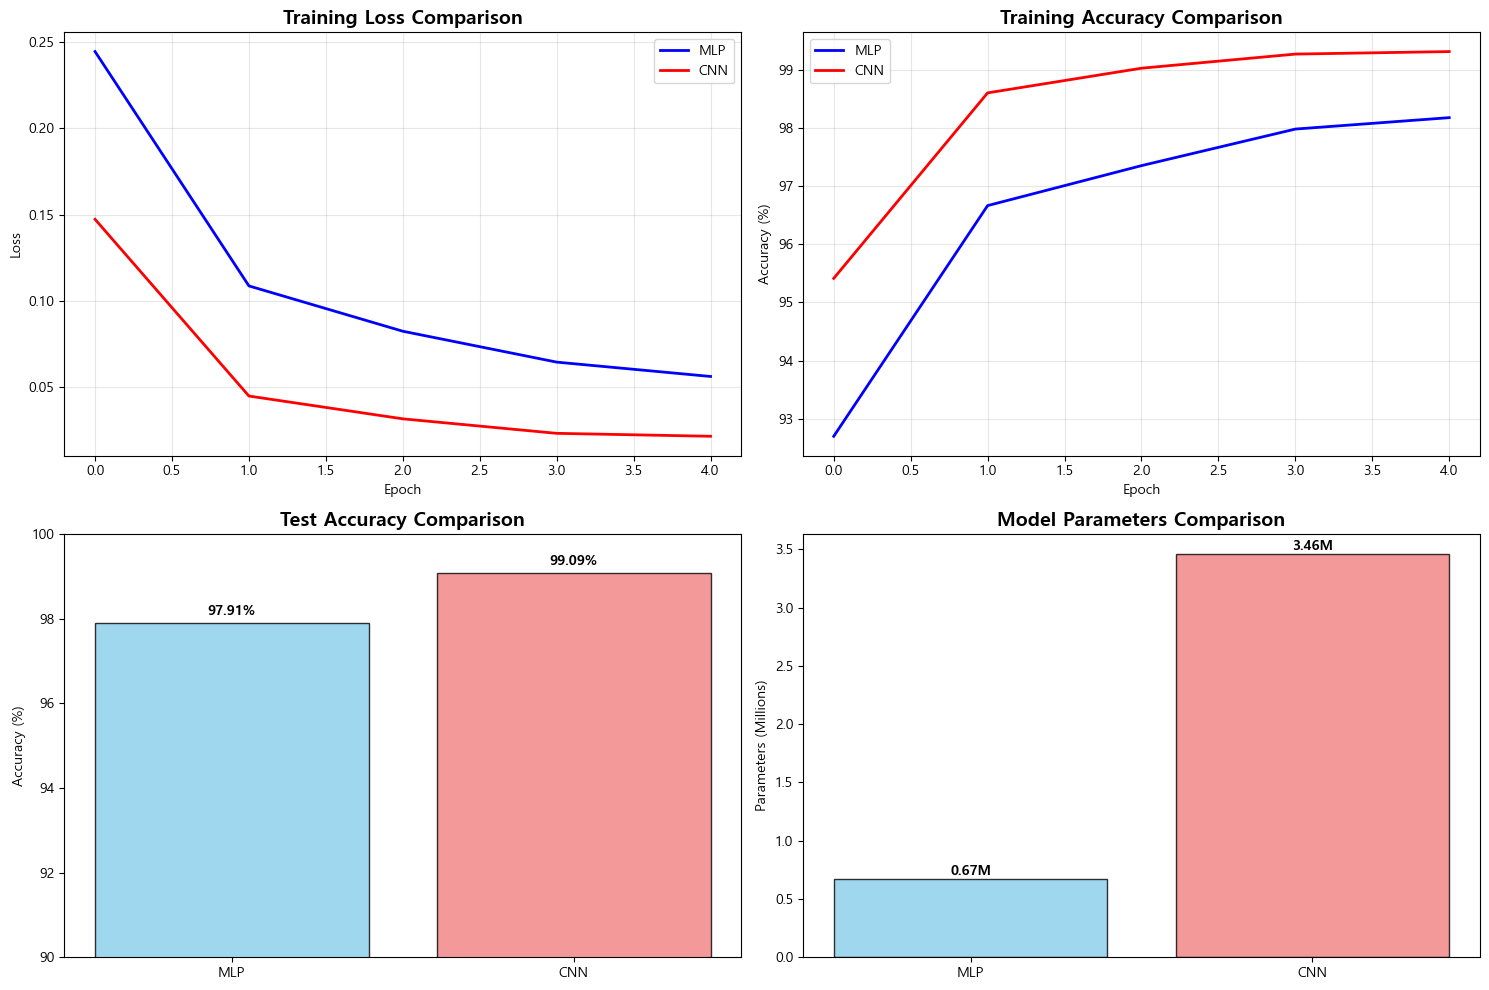

In [10]:
# 학습 곡선 시각화
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. 학습 손실 비교
ax1.plot(mlp_train_losses, 'b-', label='MLP', linewidth=2)
ax1.plot(cnn_train_losses, 'r-', label='CNN', linewidth=2)
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 학습 정확도 비교
ax2.plot(mlp_train_accuracies, 'b-', label='MLP', linewidth=2)
ax2.plot(cnn_train_accuracies, 'r-', label='CNN', linewidth=2)
ax2.set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 성능 비교 막대 그래프
models = ['MLP', 'CNN']
accuracies = [mlp_accuracy, cnn_accuracy]
colors = ['skyblue', 'lightcoral']

bars = ax3.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')
ax3.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('Accuracy (%)')
ax3.set_ylim(90, 100)

# 막대 위에 정확도 값 표시
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

# 4. 파라미터 수 비교
param_counts = [sum(p.numel() for p in mlp_model.parameters()), 
                sum(p.numel() for p in cnn_model.parameters())]
param_counts_millions = [count/1e6 for count in param_counts]

bars2 = ax4.bar(models, param_counts_millions, color=colors, alpha=0.8, edgecolor='black')
ax4.set_title('Model Parameters Comparison', fontsize=14, fontweight='bold')
ax4.set_ylabel('Parameters (Millions)')

# 막대 위에 파라미터 수 표시
for bar, count in zip(bars2, param_counts_millions):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{count:.2f}M', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## 7. 결론 및 학습 정리

### 🎯 주요 학습 내용

1. **CNN의 우수성 확인**
   - 이미지 데이터에서 CNN이 MLP보다 일반적으로 더 나은 성능
   - 공간적 정보 보존으로 특징 추출 능력 향상

2. **모델 비교 분석**
   - 파라미터 효율성
   - 학습 속도와 수렴성
   - 일반화 성능

3. **실무 적용 관점**
   - 이미지 분류 문제에서 CNN 선택의 근거
   - 모델 복잡도와 성능의 트레이드오프
